<a href="https://colab.research.google.com/github/vsadykov/kineticsim_reader/blob/main/ML_VDFs_modeltesting_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules and dependences

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

# Loading VDFs and augmenting them with the particle abundances

In [3]:
featurevector_allvdfs_all_4040 = np.load('allsimulations.mldata_vdfs_4040.npy')
featurevector_allvdfs_all_6060 = np.load('allsimulations.mldata_vdfs_6060.npy')
print(featurevector_allvdfs_all_4040.shape)
print(featurevector_allvdfs_all_6060.shape)

(1253, 2, 40, 40)
(1253, 2, 60, 60)


In [4]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
print(featurevector_allmoments.shape)
pops_h = featurevector_allmoments[:,18]
pops_he = featurevector_allmoments[:,19]

(1253, 20)


In [5]:
ncases = featurevector_allvdfs_all_4040.shape[0]

featurevector_allvdfs_all_4040_aug = np.zeros([ncases,4,40,40], dtype=float)
featurevector_allvdfs_all_4040_aug[:,0:2,:,:] = np.log10(featurevector_allvdfs_all_4040 + 1)
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_4040_aug[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_4040_aug[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_4040_aug[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_4040_aug[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_4040_aug[ncase,1,:,:])
  featurevector_allvdfs_all_4040_aug[ncase,2,:,:] += pops_h[ncase]
  featurevector_allvdfs_all_4040_aug[ncase,3,:,:] += pops_he[ncase]

featurevector_allvdfs_all_6060_aug = np.zeros([ncases,4,60,60], dtype=float)
featurevector_allvdfs_all_6060_aug[:,0:2,:,:] = np.log10(featurevector_allvdfs_all_6060 + 1)
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_6060_aug[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_6060_aug[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_6060_aug[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_6060_aug[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_6060_aug[ncase,1,:,:])
  featurevector_allvdfs_all_6060_aug[ncase,2,:,:] += pops_h[ncase]
  featurevector_allvdfs_all_6060_aug[ncase,3,:,:] += pops_he[ncase]

print(featurevector_allvdfs_all_4040_aug.shape)
print(featurevector_allvdfs_all_6060_aug.shape)

(1253, 4, 40, 40)
(1253, 4, 60, 60)


0.9 0.9
0.05 0.05


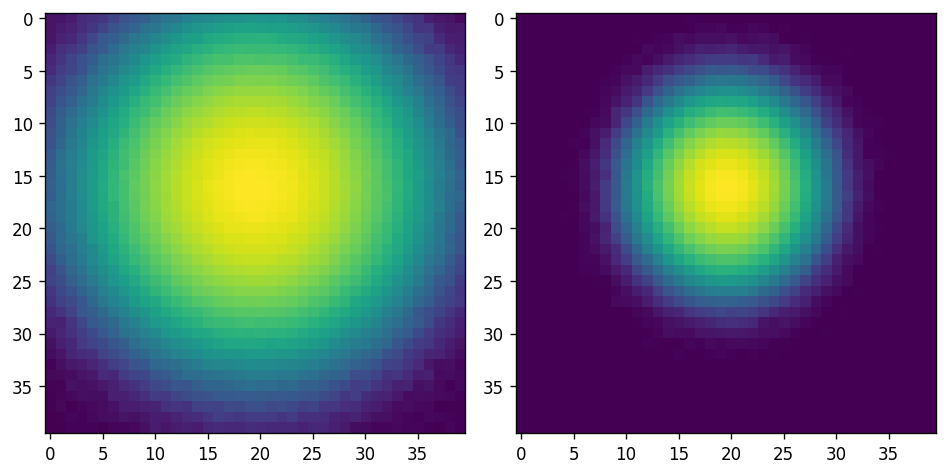

In [6]:
im, ax = plt.subplots(1, 2, figsize=(8,8), dpi=120)

ax[0].imshow(featurevector_allvdfs_all_4040_aug[100,0,:,:])
ax[1].imshow(featurevector_allvdfs_all_4040_aug[100,1,:,:])

print(np.amin(featurevector_allvdfs_all_4040_aug[100,2,:,:]), np.amax(featurevector_allvdfs_all_4040_aug[100,2,:,:]))
print(np.amin(featurevector_allvdfs_all_4040_aug[100,3,:,:]), np.amax(featurevector_allvdfs_all_4040_aug[100,3,:,:]))

plt.tight_layout()
plt.show()

Loading labels for 0.001 anisotropy or magnetic energy change

In [7]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('allsimulations.timep_array_all.npy')
labels_an = np.load('allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

print(labels_allmoments.shape)

The total number of data points is: 1253
Among them unstable (positive) samples: 398
(1253,)


Producing 10-CV data set separations

In [8]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x7810231e7450>

# Best architecture for 40x40 VDFs (5-fold CV for faster assessment)

In [9]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*5*5, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 5 * 5)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=1),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 5 * 5)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*10*10, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 10 * 10)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*10*10, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 10 * 10)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*20*20, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 20 * 20)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*20*20, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 20 * 20)
    x = self.linearcell(x)
    return x

In [10]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 3000/3000 [02:08<00:00, 23.40it/s]


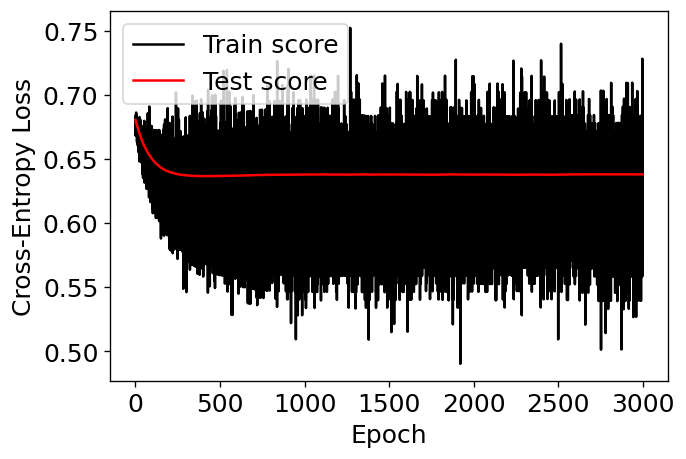

<ipython-input-10-be7d2eddc1a2>:3: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


Optimal epoch count for the current training: 417
0.6666666666666666 2925
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [02:03<00:00, 24.26it/s]


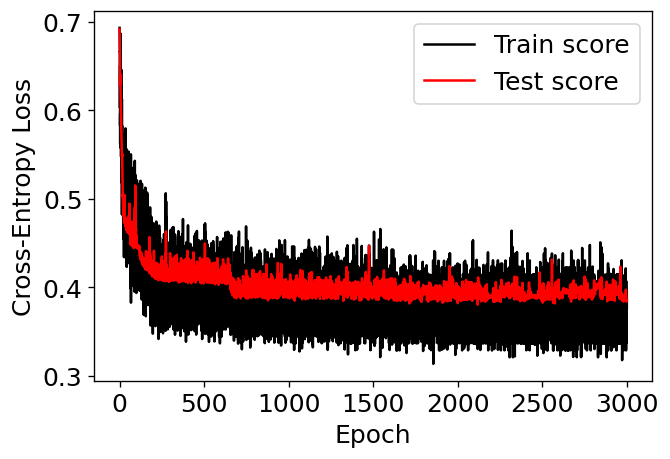

Optimal epoch count for the current training: 2117
0.9347826086956522 14825
0.9347826086956522 0.8478260869565217
---------------------------------------------


100%|██████████| 3000/3000 [02:04<00:00, 24.18it/s]


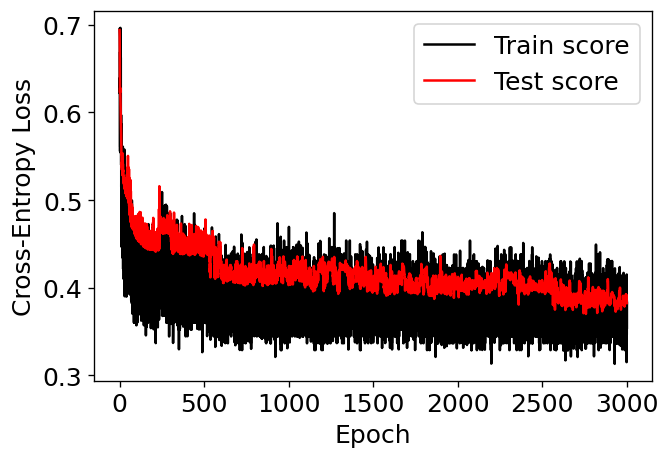

Optimal epoch count for the current training: 2757
0.9444444444444444 19304
0.9444444444444444 0.8508281379605597
---------------------------------------------


100%|██████████| 3000/3000 [02:06<00:00, 23.70it/s]


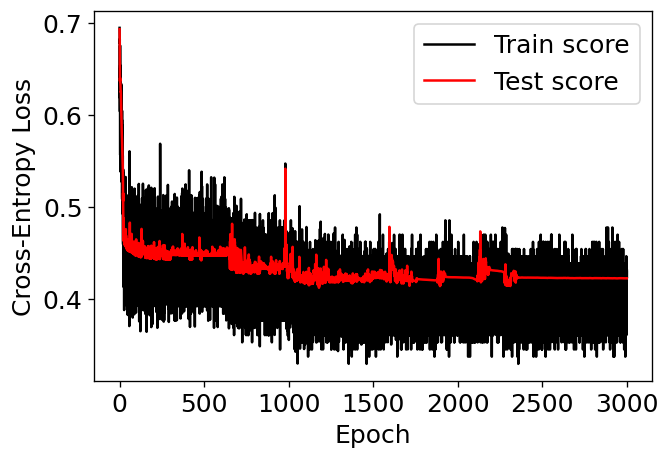

Optimal epoch count for the current training: 1179
0.9009661835748792 8254
0.9009661835748792 0.7355072463768115
---------------------------------------------


100%|██████████| 3000/3000 [02:06<00:00, 23.68it/s]


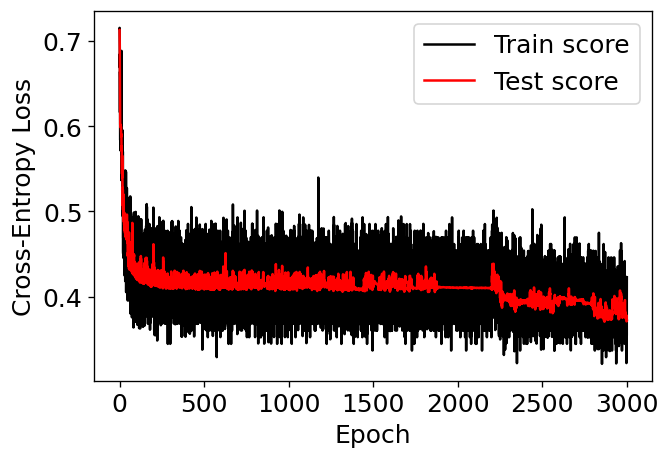

Optimal epoch count for the current training: 2867
0.9420289855072463 20073
0.9420289855072463 0.8598708148816743
---------------------------------------------


100%|██████████| 3000/3000 [02:05<00:00, 23.90it/s]


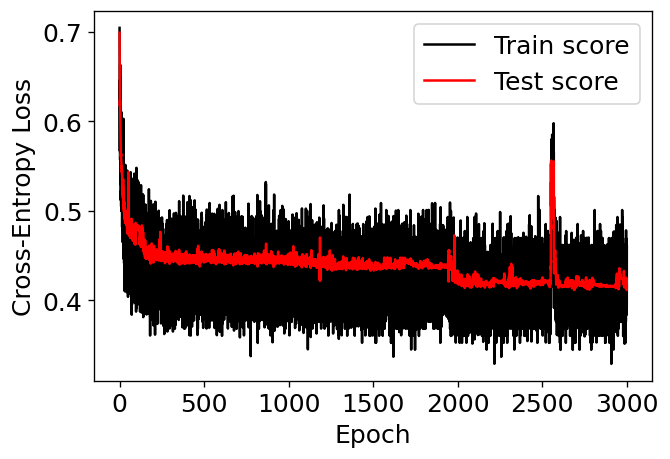

Optimal epoch count for the current training: 2999
0.9009661835748792 20995
0.9009661835748792 0.7392502608835255
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN2
TP = 111.6+/-7.002856560004638
TN = 271.2+/-6.079473661428265
FP = 10.2+/-2.4
FN = 21.0+/-7.974960814950754
Acc = 0.9246376811594204+/-0.01958756998329786
TSS = 0.8066565094118185+/-0.05671622195030101


In [11]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_4040_CNN3_CONN1
ARCH = 'VDFCNN_4040_CNN3_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_4040_CNN2_CONN2
ARCH = 'VDFCNN_4040_CNN2_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_4040_CNN2_CONN1
ARCH = 'VDFCNN_4040_CNN2_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

100%|██████████| 3000/3000 [01:40<00:00, 29.97it/s]


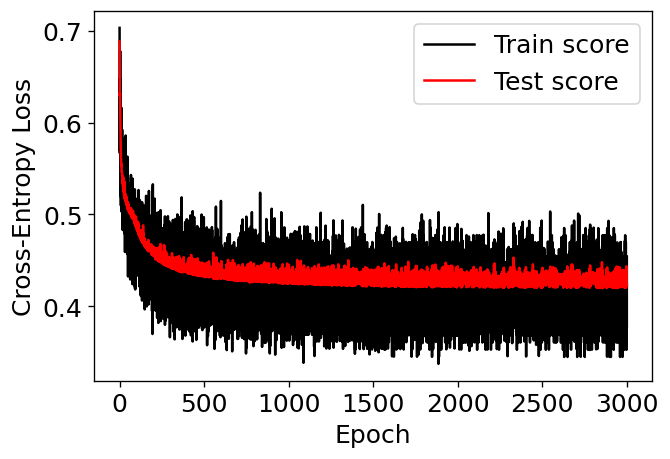

Optimal epoch count for the current training: 2854
0.893719806763285 19981
0.893719806763285 0.6920289855072463
---------------------------------------------


100%|██████████| 3000/3000 [01:37<00:00, 30.70it/s]


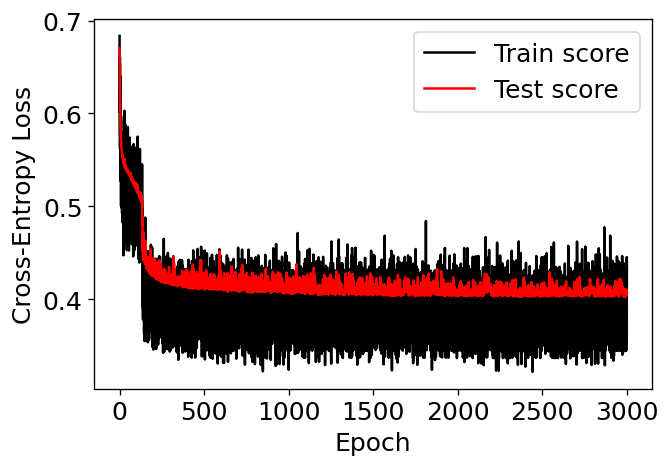

Optimal epoch count for the current training: 2991
0.9106280193236715 20942
0.9106280193236715 0.797045995772349
---------------------------------------------


100%|██████████| 3000/3000 [01:37<00:00, 30.88it/s]


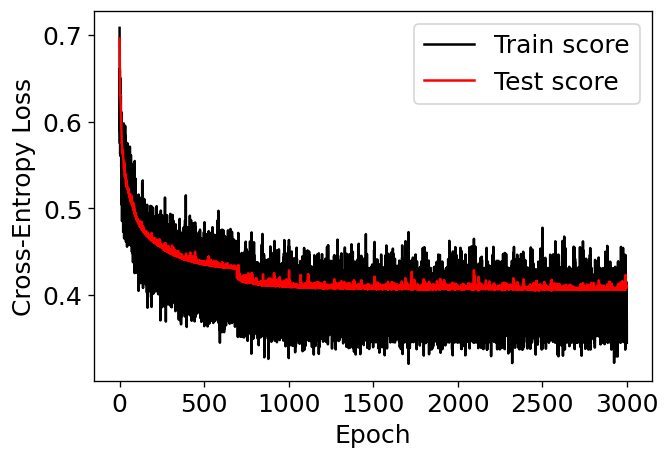

Optimal epoch count for the current training: 2479
0.9106280193236715 17357
0.9106280193236715 0.75
---------------------------------------------


100%|██████████| 3000/3000 [01:39<00:00, 30.19it/s]


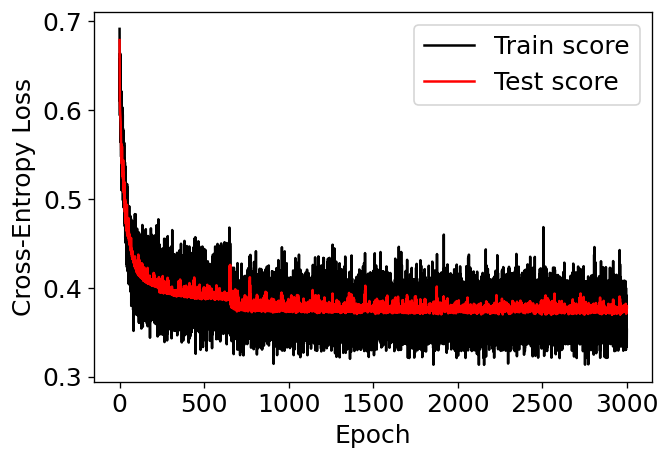

Optimal epoch count for the current training: 2553
0.9468599033816425 17872
0.9468599033816425 0.8715482469748681
---------------------------------------------


100%|██████████| 3000/3000 [01:37<00:00, 30.71it/s]


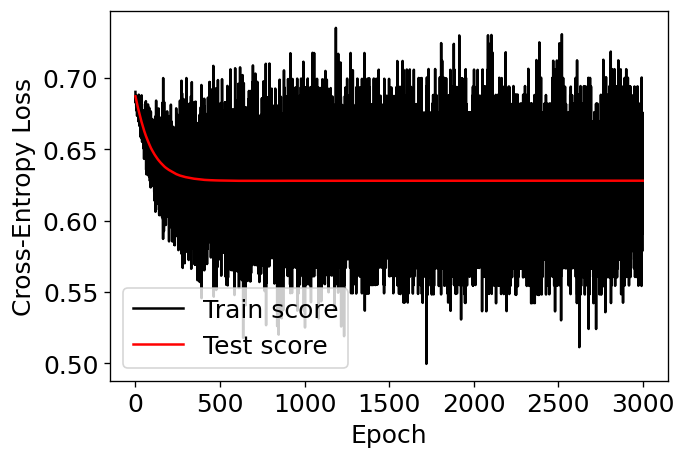

<ipython-input-10-be7d2eddc1a2>:3: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


Optimal epoch count for the current training: 727
0.678743961352657 5089
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [01:36<00:00, 31.24it/s]


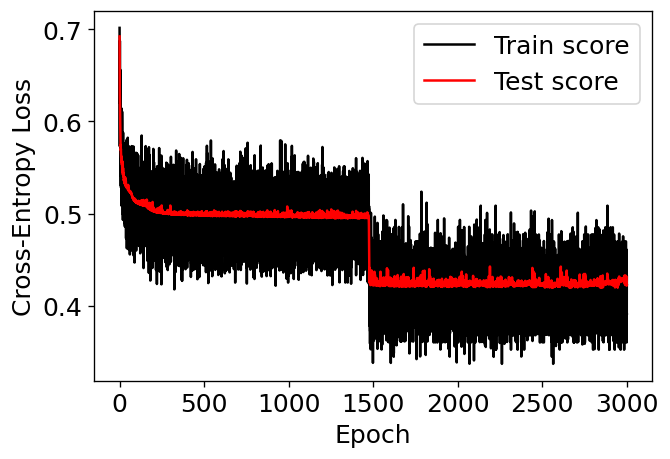

Optimal epoch count for the current training: 2556
0.893719806763285 17892
0.893719806763285 0.716693869906082
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
TP = 105.8+/-6.368673331236263
TN = 271.4+/-6.468384651518491
FP = 10.0+/-5.656854249492381
FN = 26.8+/-10.796295661012623
Acc = 0.9111111111111111+/-0.019408028431498234
TSS = 0.7654634196321092+/-0.06365791726161636


In [13]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

CONCLUSION:

Best network configuration:

Running for the best configuration now...

# Best architecture for 60x60 VDFs (5-fold CV for faster assessment)

In [14]:
class VDFCNN_6060_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*7*7, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 7 * 7)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=1),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*7*7, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 7 * 7)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*15*15, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 15 * 15)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*15*15, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 16 * 15 * 15)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*30*30, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 30 * 30)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*30*30, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 30 * 30)
    x = self.linearcell(x)
    return x

100%|██████████| 3000/3000 [03:35<00:00, 13.89it/s]


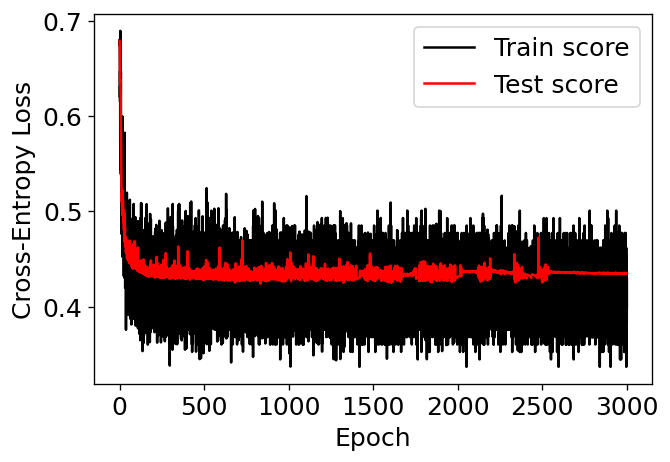

Optimal epoch count for the current training: 833
0.8888888888888888 5834
0.8888888888888888 0.7246376811594203
---------------------------------------------


100%|██████████| 3000/3000 [03:44<00:00, 13.38it/s]


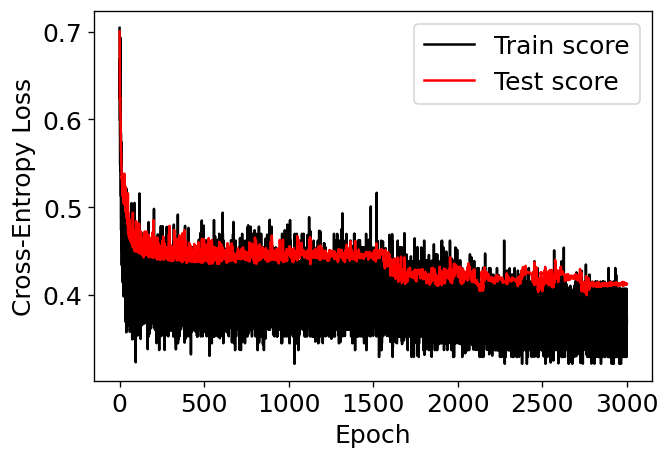

Optimal epoch count for the current training: 2761
0.9154589371980676 19333
0.9154589371980676 0.8160436678885826
---------------------------------------------


100%|██████████| 3000/3000 [03:47<00:00, 13.21it/s]


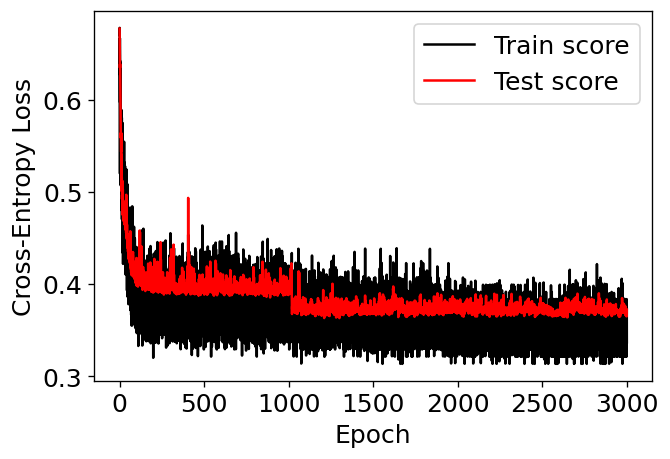

Optimal epoch count for the current training: 1300
0.9516908212560387 9100
0.9516908212560387 0.8695652173913044
---------------------------------------------


100%|██████████| 3000/3000 [03:39<00:00, 13.65it/s]


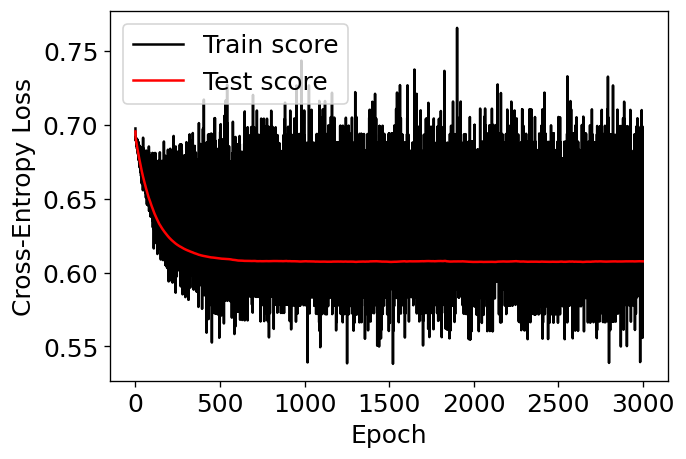

<ipython-input-10-be7d2eddc1a2>:3: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


Optimal epoch count for the current training: 2010
0.7077294685990339 14074
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [03:36<00:00, 13.84it/s]


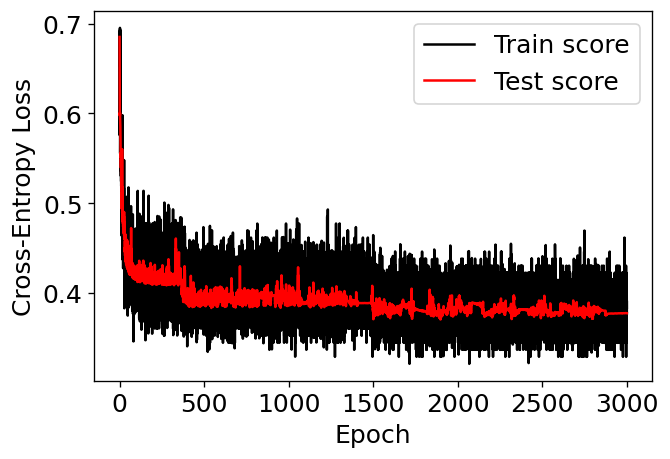

Optimal epoch count for the current training: 1897
0.9420289855072463 13285
0.9420289855072463 0.8550193213550334
---------------------------------------------


100%|██████████| 3000/3000 [03:38<00:00, 13.74it/s]


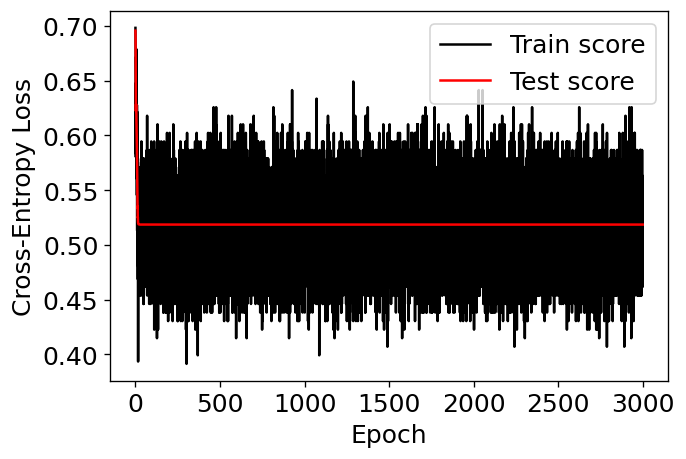

Optimal epoch count for the current training: 230
0.7946859903381642 1614
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [03:38<00:00, 13.72it/s]


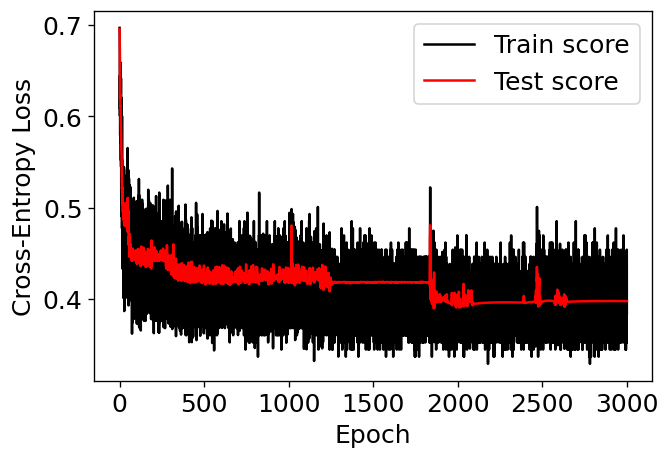

Optimal epoch count for the current training: 1858
0.9251207729468599 13008
0.9251207729468599 0.82235838707088
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
TP = 114.4+/-5.571355310873647
TN = 268.4+/-8.06473806146238
FP = 13.0+/-5.366563145999495
FN = 18.2+/-6.04648658313239
Acc = 0.9246376811594204+/-0.021894239987680517
TSS = 0.8175248549730441+/-0.05053240215286892


In [15]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN1
ARCH = 'VDFCNN_6060_CNN3_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN2_CONN2
ARCH = 'VDFCNN_6060_CNN2_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN2_CONN1
ARCH = 'VDFCNN_6060_CNN2_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [ ]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

In [1]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

NameError: name 'np' is not defined

# Experiment 1. 40x40 VDFs, 0.15VA resolution.

## Preparing the data set

In [ ]:
featurevector_allvdfs_all = np.load('allsimulations.mldata_vdfs_4040.npy')
labels_allvdfs_all = np.load('allsimulations.mldata_labels_4040.npy')
timep_array_all = np.load('allsimulations.mldata_timep_4040.npy')

Log normalization of the VDFs

In [ ]:
featurevector_allvdfs_all = np.log10(featurevector_allvdfs_all + 1)
for t in range (0, featurevector_allvdfs_all.shape[0], 1):
  featurevector_allvdfs_all[t,0,:,:] /= np.amax(featurevector_allvdfs_all[t,0,:,:])
  featurevector_allvdfs_all[t,1,:,:] /= np.amax(featurevector_allvdfs_all[t,1,:,:])

In [ ]:
X_train, X_test, f_train, f_test = train_test_split(featurevector_allvdfs_all, labels_allvdfs_all, \
                                                    test_size=0.33, random_state=1)

In [ ]:
print("Shapes of the data sets:")
print(X_train.shape, f_train.shape)
print(X_test.shape, f_test.shape)

Shapes of the data sets:
(667, 2, 40, 40) (667,)
(330, 2, 40, 40) (330,)


In [ ]:
random_indices = np.random.choice(X_train.shape[0], size=128, replace=False)
X_select = X_train[random_indices]
print(X_select.shape)

(128, 2, 40, 40)


## CNN prototype (with no early stopping first)

In [ ]:
class VDFCNN(nn.Module):
  def __init__(self):
    super(VDFCNN, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 5 * 5)
    x = self.linearcell(x)
    return x

In [ ]:
device = torch.device("cuda:0")
net = VDFCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

loss_history_train = []
loss_history_test = []

outputs_history_train = []
outputs_labels_train = []
outputs_history_test = []
outputs_labels_test = []

n_epochs = 2000
n_iterations = 6 # based on the total size / batch size, approximately

# test data tensors
testdata_tensor = torch.tensor(X_test).float().to(device=device)
testlabels_tensor = torch.tensor(f_test).long().to(device=device)

for ep in tqdm(range(n_epochs)):
  for n_iter in range (n_iterations):
    train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
    traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
    trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
    outputs = net(traindata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, trainlabels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history_train.append(loss.item())
    outputs_history_train.append(outputs.detach())
    outputs_labels_train.append(f_train[train_indexes])
    outputs = net(testdata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, testlabels_tensor)
    loss_history_test.append(loss.item())
    outputs_history_test.append(outputs.detach())
    outputs_labels_test.append(f_test)

100%|██████████| 2000/2000 [01:05<00:00, 30.77it/s]


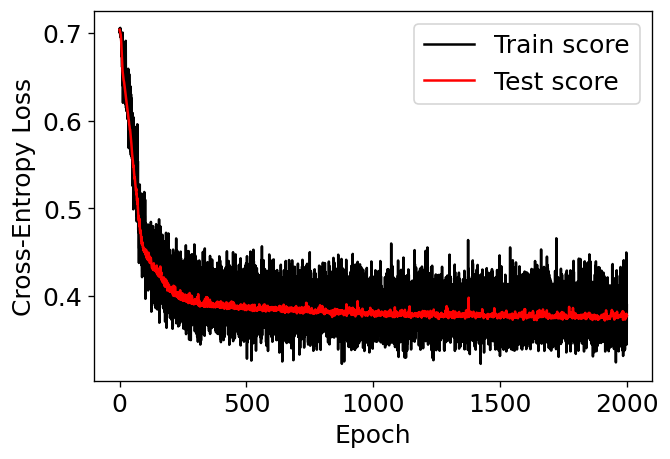

In [ ]:
matplotlib.rcParams.update({'font.size': 15})
im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
ax.legend()
plt.show()

In [ ]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

In [ ]:
optim_index = np.argmin(np.array(loss_history_test))
print("Optimal epoch count for the current training:", optim_index//n_iterations)

outputs_optim = outputs_history_test[optim_index]
labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

outputclass_analysis(f_test, labels_optim)

Optimal epoch count for the current training: 1913
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 118
TN = 192
FP = 11
FN = 9
Precision = 0.9147286821705426
Recall = 0.9291338582677166
Accuracy = 0.9393939393939394
TSS = 0.8749466661494899
HSS = 0.8723749854971574


## Another version with ReLU activation function

In [ ]:
class VDFCNN2(nn.Module):
  def __init__(self):
    super(VDFCNN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.ReLU(True)
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 5 * 5)
    x = self.linearcell(x)
    return x

In [ ]:
device = torch.device("cuda:0")
net = VDFCNN2().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

loss_history_train = []
loss_history_test = []

outputs_history_train = []
outputs_labels_train = []
outputs_history_test = []
outputs_labels_test = []

n_epochs = 2000
n_iterations = 6 # based on the total size / batch size, approximately

# test data tensors
testdata_tensor = torch.tensor(X_test).float().to(device=device)
testlabels_tensor = torch.tensor(f_test).long().to(device=device)

for ep in tqdm(range(n_epochs)):
  for n_iter in range (n_iterations):
    train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
    traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
    trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
    outputs = net(traindata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, trainlabels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history_train.append(loss.item())
    outputs_history_train.append(outputs.detach())
    outputs_labels_train.append(f_train[train_indexes])
    outputs = net(testdata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, testlabels_tensor)
    loss_history_test.append(loss.item())
    outputs_history_test.append(outputs.detach())
    outputs_labels_test.append(f_test)

100%|██████████| 2000/2000 [01:10<00:00, 28.32it/s]


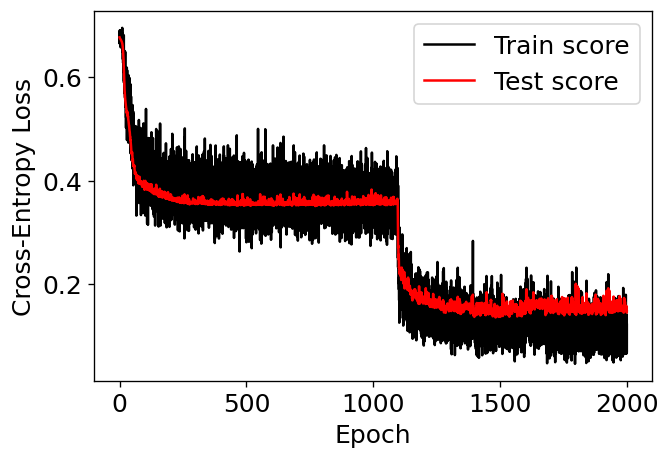

In [ ]:
matplotlib.rcParams.update({'font.size': 15})
im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
ax.legend()
plt.show()

In [ ]:
optim_index = np.argmin(np.array(loss_history_test))
print("Optimal epoch count for the current training:", optim_index//n_iterations)

outputs_optim = outputs_history_test[optim_index]
labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

outputclass_analysis(f_test, labels_optim)

Optimal epoch count for the current training: 1482
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 121
TN = 196
FP = 7
FN = 6
Precision = 0.9453125
Recall = 0.952755905511811
Accuracy = 0.9606060606060606
TSS = 0.9182731468911214
HSS = 0.9169216468492196


# Experiment 2. 60x60 VDFs, 0.10VA resolution.

In [ ]:
featurevector_allvdfs_all = np.load('allsimulations.mldata_vdfs_6060.npy')
labels_allvdfs_all = np.load('allsimulations.mldata_labels_6060.npy')
timep_array_all = np.load('allsimulations.mldata_timep_6060.npy')

In [ ]:
featurevector_allvdfs_all = np.log10(featurevector_allvdfs_all + 1)
for t in range (0, featurevector_allvdfs_all.shape[0], 1):
  featurevector_allvdfs_all[t,0,:,:] /= np.amax(featurevector_allvdfs_all[t,0,:,:])
  featurevector_allvdfs_all[t,1,:,:] /= np.amax(featurevector_allvdfs_all[t,1,:,:])

In [ ]:
X_train, X_test, f_train, f_test = train_test_split(featurevector_allvdfs_all, labels_allvdfs_all, \
                                                    test_size=0.33, random_state=1)

## Sigmoid activation at the end

In [ ]:
class VDFCNN(nn.Module):
  def __init__(self):
    super(VDFCNN, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=3, stride=3),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 5 * 5)
    x = self.linearcell(x)
    return x

In [ ]:
device = torch.device("cuda:0")
net = VDFCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.00025)

loss_history_train = []
loss_history_test = []

outputs_history_train = []
outputs_labels_train = []
outputs_history_test = []
outputs_labels_test = []

n_epochs = 2000
n_iterations = 6 # based on the total size / batch size, approximately

# test data tensors
testdata_tensor = torch.tensor(X_test).float().to(device=device)
testlabels_tensor = torch.tensor(f_test).long().to(device=device)

for ep in tqdm(range(n_epochs)):
  for n_iter in range (n_iterations):
    train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
    traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
    trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
    outputs = net(traindata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, trainlabels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history_train.append(loss.item())
    outputs_history_train.append(outputs.detach())
    outputs_labels_train.append(f_train[train_indexes])
    outputs = net(testdata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, testlabels_tensor)
    loss_history_test.append(loss.item())
    outputs_history_test.append(outputs.detach())
    outputs_labels_test.append(f_test)

100%|██████████| 2000/2000 [01:59<00:00, 16.72it/s]


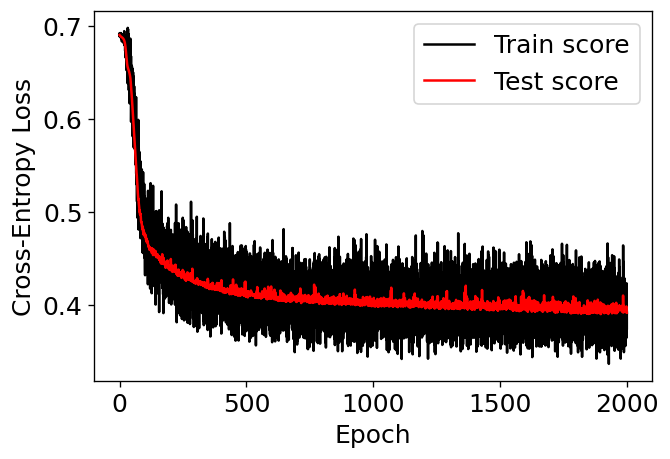

In [ ]:
matplotlib.rcParams.update({'font.size': 15})
im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
ax.legend()
plt.show()

In [ ]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

In [ ]:
optim_index = np.argmin(np.array(loss_history_test))
print("Optimal epoch count for the current training:", optim_index//n_iterations)

outputs_optim = outputs_history_test[optim_index]
labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

outputclass_analysis(f_test, labels_optim)

Optimal epoch count for the current training: 1896
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 105
TN = 202
FP = 1
FN = 22
Precision = 0.9905660377358491
Recall = 0.8267716535433071
Accuracy = 0.9303030303030303
TSS = 0.8218455451689228
HSS = 0.8480967057599167


## ReLU activation at the end

In [ ]:
class VDFCNN2(nn.Module):
  def __init__(self):
    super(VDFCNN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=3, stride=3),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.ReLU(True)
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 5 * 5)
    x = self.linearcell(x)
    return x

In [ ]:
device = torch.device("cuda:0")
net = VDFCNN2().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

loss_history_train = []
loss_history_test = []

outputs_history_train = []
outputs_labels_train = []
outputs_history_test = []
outputs_labels_test = []

n_epochs = 2000
n_iterations = 6 # based on the total size / batch size, approximately

# test data tensors
testdata_tensor = torch.tensor(X_test).float().to(device=device)
testlabels_tensor = torch.tensor(f_test).long().to(device=device)

for ep in tqdm(range(n_epochs)):
  for n_iter in range (n_iterations):
    train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
    traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
    trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
    outputs = net(traindata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, trainlabels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history_train.append(loss.item())
    outputs_history_train.append(outputs.detach())
    outputs_labels_train.append(f_train[train_indexes])
    outputs = net(testdata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, testlabels_tensor)
    loss_history_test.append(loss.item())
    outputs_history_test.append(outputs.detach())
    outputs_labels_test.append(f_test)

100%|██████████| 2000/2000 [01:57<00:00, 16.98it/s]


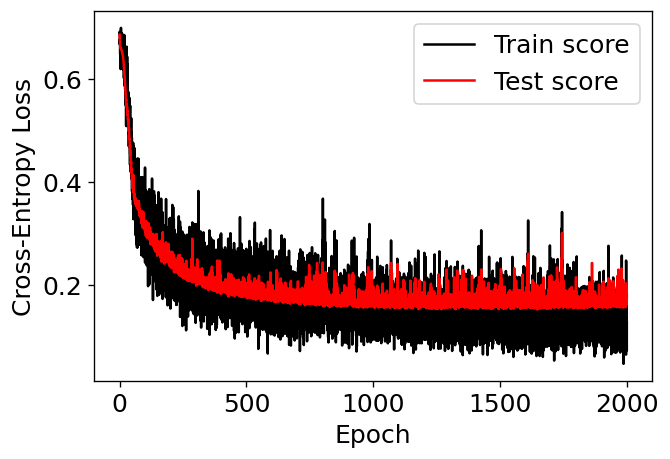

In [ ]:
matplotlib.rcParams.update({'font.size': 15})
im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
ax.legend()
plt.show()

In [ ]:
optim_index = np.argmin(np.array(loss_history_test))
print("Optimal epoch count for the current training:", optim_index//n_iterations)

outputs_optim = outputs_history_test[optim_index]
labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

outputclass_analysis(f_test, labels_optim)

Optimal epoch count for the current training: 1647
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 110
TN = 200
FP = 3
FN = 17
Precision = 0.9734513274336283
Recall = 0.8661417322834646
Accuracy = 0.9393939393939394
TSS = 0.8513634071603119
HSS = 0.8693017545249316


# Experiment 3. Both networks run 10 times.

### Resolution of 0.15 $V_{A}$

In [ ]:
featurevector_allvdfs_all = np.load('allsimulations.mldata_vdfs_4040.npy')
labels_allvdfs_all = np.load('allsimulations.mldata_labels_4040.npy')
timep_array_all = np.load('allsimulations.mldata_timep_4040.npy')

featurevector_allvdfs_all = np.log10(featurevector_allvdfs_all + 1)
for t in range (0, featurevector_allvdfs_all.shape[0], 1):
  featurevector_allvdfs_all[t,0,:,:] /= np.amax(featurevector_allvdfs_all[t,0,:,:])
  featurevector_allvdfs_all[t,1,:,:] /= np.amax(featurevector_allvdfs_all[t,1,:,:])

In [ ]:
class VDFCNN(nn.Module):
  def __init__(self):
    super(VDFCNN, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2)
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 5 * 5)
    x = self.linearcell(x)
    return x

In [ ]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 2000/2000 [01:06<00:00, 30.07it/s]


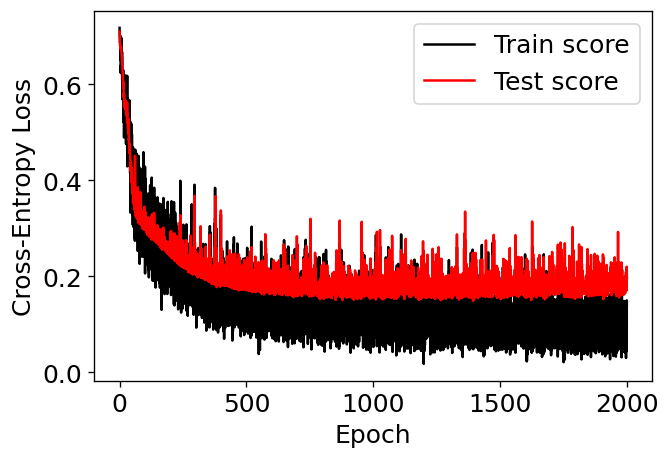

Optimal epoch count for the current training: 1393
0.9545454545454546 0.8998629302467256
---------------------------------------------


100%|██████████| 2000/2000 [01:03<00:00, 31.48it/s]


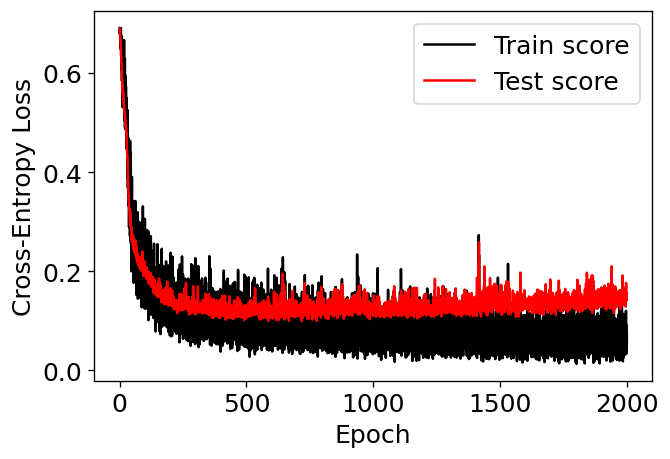

Optimal epoch count for the current training: 717
0.9757575757575757 0.9429036887630425
---------------------------------------------


100%|██████████| 2000/2000 [01:03<00:00, 31.45it/s]


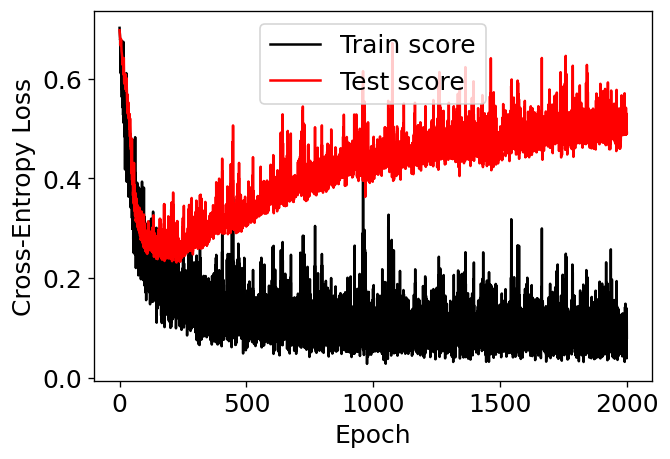

Optimal epoch count for the current training: 224
0.9333333333333333 0.8597744360902255
---------------------------------------------


100%|██████████| 2000/2000 [01:03<00:00, 31.34it/s]


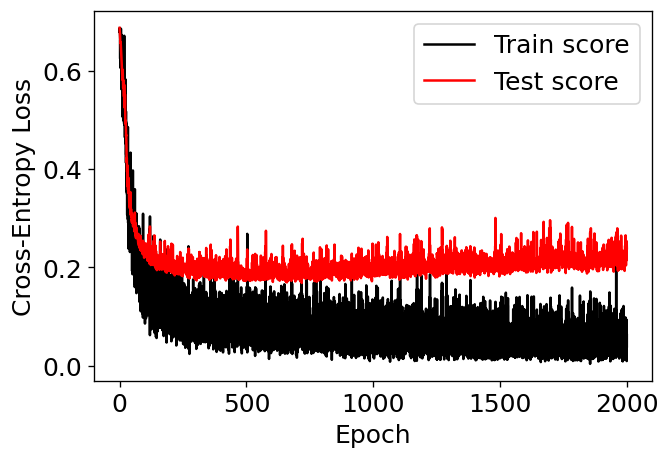

Optimal epoch count for the current training: 718
0.9606060606060606 0.911006670709521
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 31.02it/s]


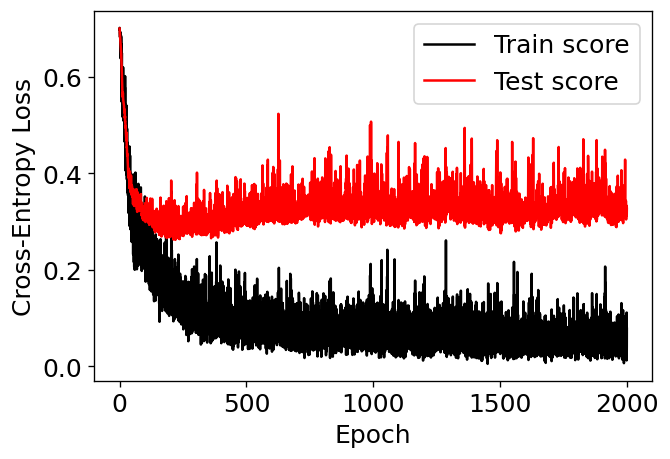

Optimal epoch count for the current training: 220
0.9424242424242424 0.866597246326507
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 31.21it/s]


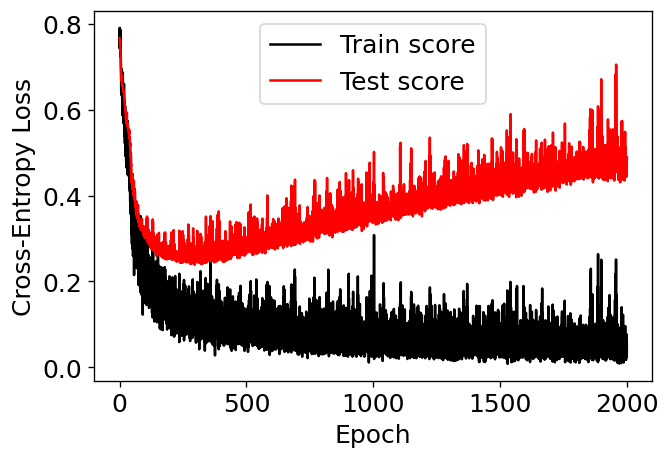

Optimal epoch count for the current training: 296
0.9303030303030303 0.847243374961925
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 31.09it/s]


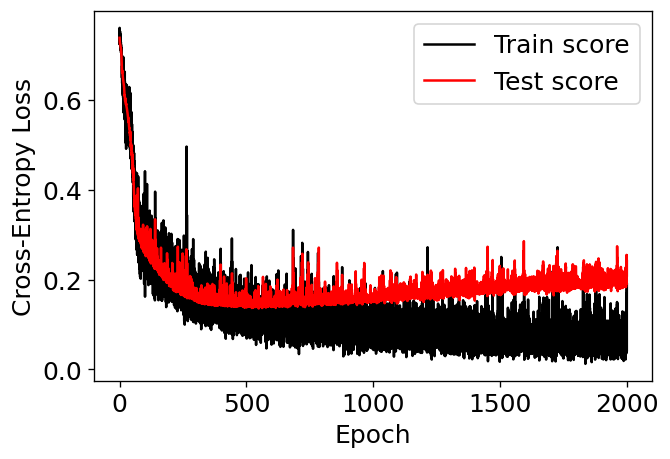

Optimal epoch count for the current training: 548
0.9545454545454546 0.896988664554788
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 31.03it/s]


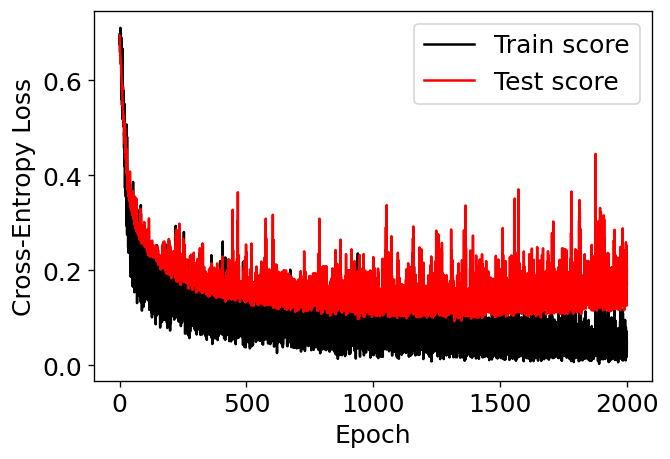

Optimal epoch count for the current training: 1320
0.9636363636363636 0.9107142857142858
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.77it/s]


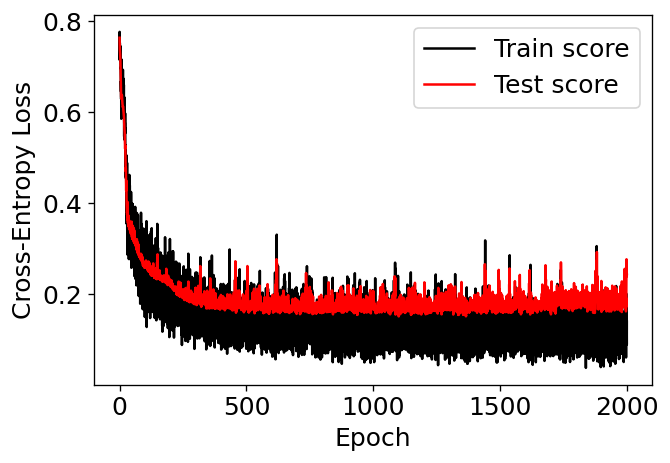

Optimal epoch count for the current training: 1100
0.9242424242424242 0.8562091503267973
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 31.14it/s]


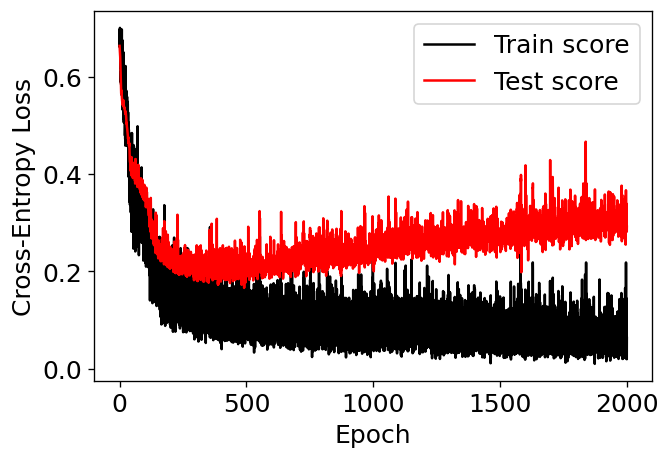

Optimal epoch count for the current training: 491
0.9515151515151515 0.8788499344692006
---------------------------------------------
TP = 118.5+/-7.433034373659253
TN = 194.7+/-9.306449376641986
FP = 6.2+/-4.445222154178574
FN = 10.6+/-2.727636339397171
Acc = 0.949090909090909+/-0.015439683882250905
TSS = 0.8870150382163018+/-0.028777993413872025


In [ ]:
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e in range (0, 10, 1):

  # formation of the data set
  X_train, X_test, f_train, f_test = train_test_split(featurevector_allvdfs_all, labels_allvdfs_all, \
                                                      test_size=0.33, random_state=n_e)

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 6 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    if ((_acc < 0.92) or (optim_index > 10000)):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

### Resolution of 0.10 $V_{A}$

In [ ]:
featurevector_allvdfs_all = np.load('allsimulations.mldata_vdfs_6060.npy')
labels_allvdfs_all = np.load('allsimulations.mldata_labels_6060.npy')
timep_array_all = np.load('allsimulations.mldata_timep_6060.npy')

featurevector_allvdfs_all = np.log10(featurevector_allvdfs_all + 1)
for t in range (0, featurevector_allvdfs_all.shape[0], 1):
  featurevector_allvdfs_all[t,0,:,:] /= np.amax(featurevector_allvdfs_all[t,0,:,:])
  featurevector_allvdfs_all[t,1,:,:] /= np.amax(featurevector_allvdfs_all[t,1,:,:])

In [ ]:
class VDFCNN(nn.Module):
  def __init__(self):
    super(VDFCNN, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=3, stride=3),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2)
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 5 * 5)
    x = self.linearcell(x)
    return x

100%|██████████| 2000/2000 [01:55<00:00, 17.37it/s]


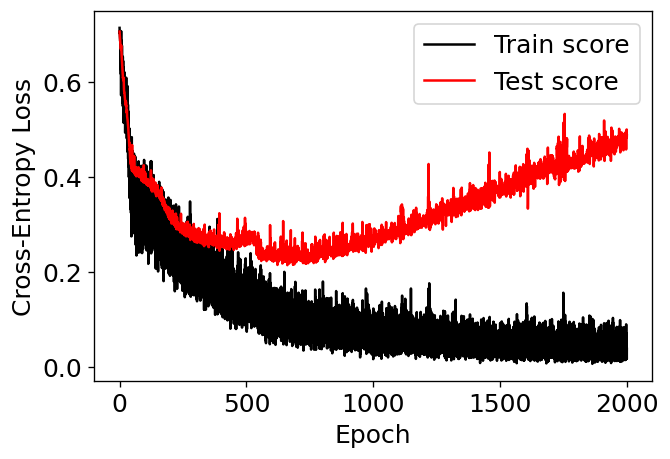

Optimal epoch count for the current training: 661
0.9575757575757575 0.9049649710630521
---------------------------------------------


100%|██████████| 2000/2000 [01:54<00:00, 17.42it/s]


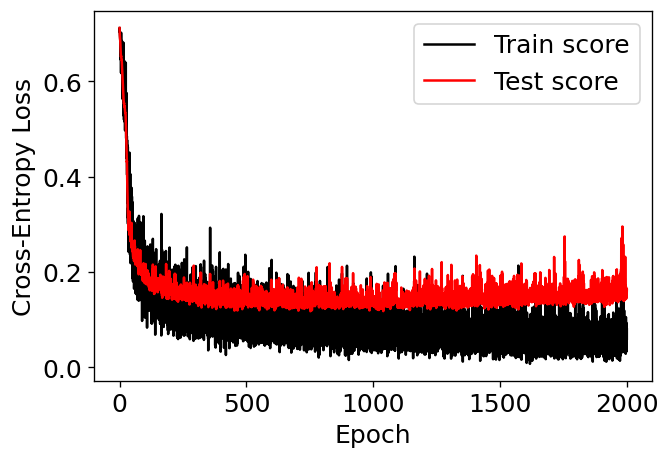

Optimal epoch count for the current training: 752
0.9666666666666667 0.9192816415189481
---------------------------------------------


100%|██████████| 2000/2000 [01:55<00:00, 17.31it/s]


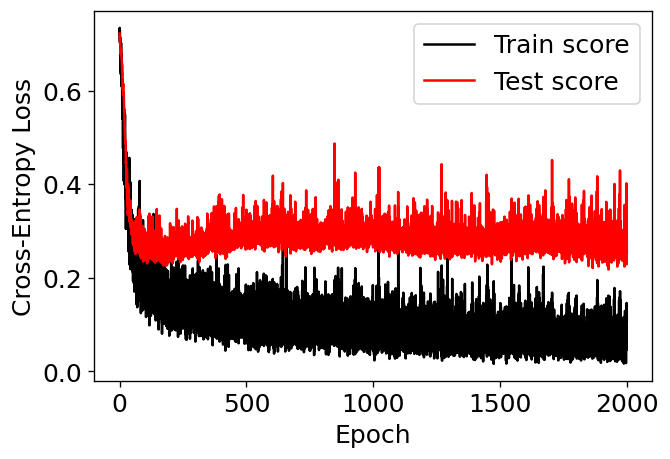

Optimal epoch count for the current training: 1927
RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:55<00:00, 17.31it/s]


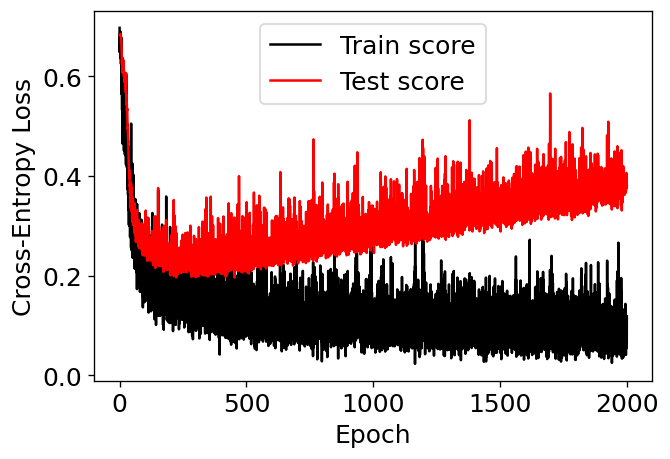

Optimal epoch count for the current training: 453
0.9484848484848485 0.893609022556391
---------------------------------------------


100%|██████████| 2000/2000 [01:55<00:00, 17.39it/s]


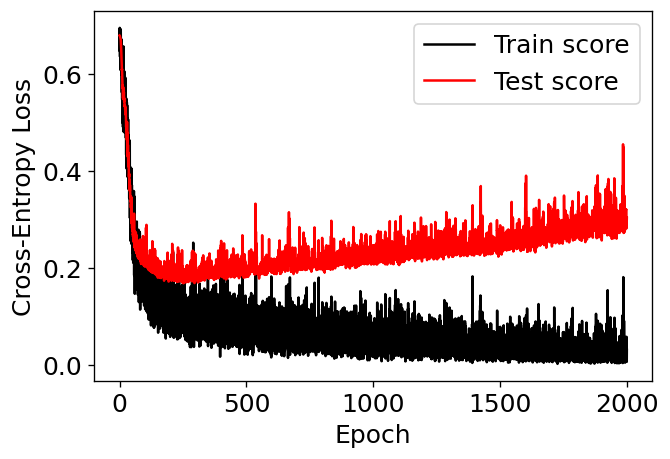

Optimal epoch count for the current training: 251
0.9333333333333333 0.853623408126137
---------------------------------------------


100%|██████████| 2000/2000 [01:55<00:00, 17.37it/s]


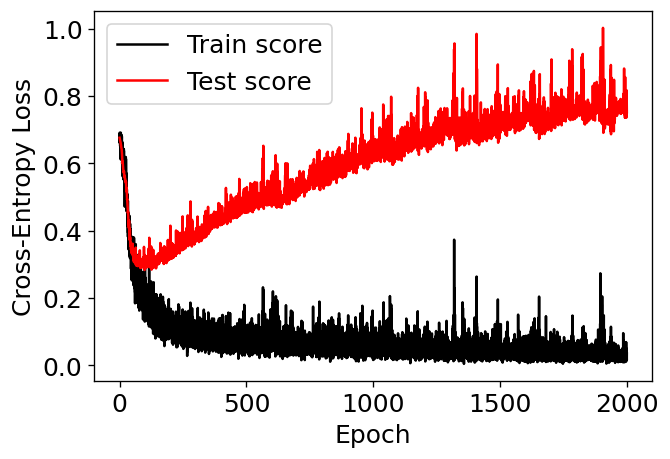

Optimal epoch count for the current training: 98
0.9242424242424242 0.8200856184195302
---------------------------------------------


100%|██████████| 2000/2000 [01:54<00:00, 17.39it/s]


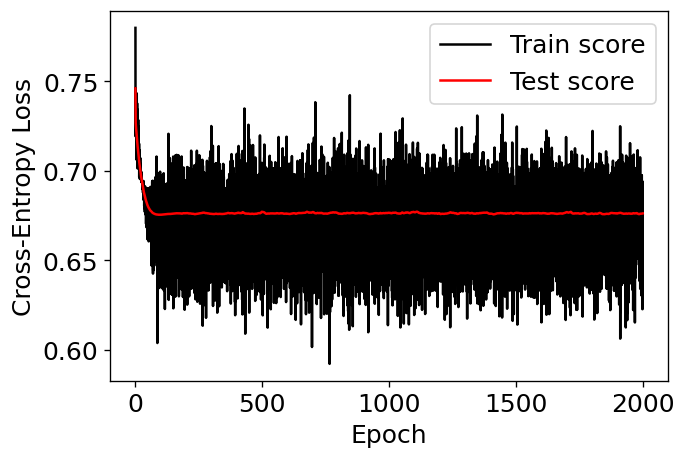

<ipython-input-61-be7d2eddc1a2>:3: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


Optimal epoch count for the current training: 96
RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:57<00:00, 17.07it/s]


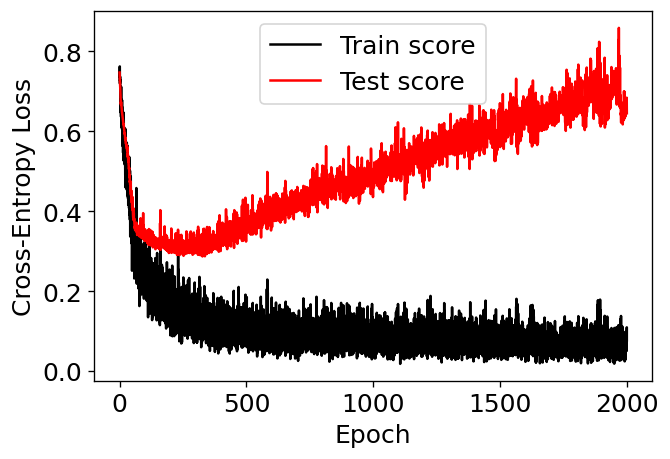

Optimal epoch count for the current training: 326
0.9272727272727272 0.8421413341455986
---------------------------------------------


100%|██████████| 2000/2000 [01:57<00:00, 17.06it/s]


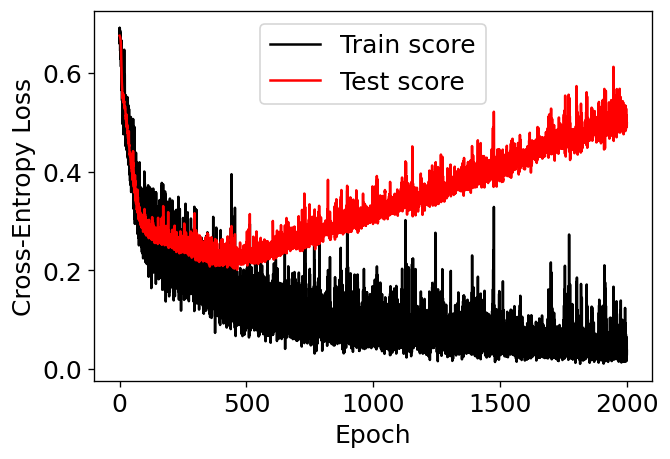

Optimal epoch count for the current training: 463
0.9515151515151515 0.8967978321438113
---------------------------------------------


100%|██████████| 2000/2000 [01:57<00:00, 17.05it/s]


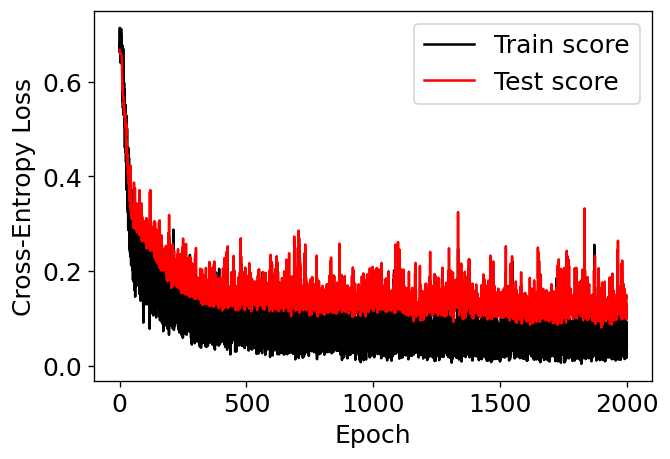

Optimal epoch count for the current training: 1899
RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:57<00:00, 17.03it/s]


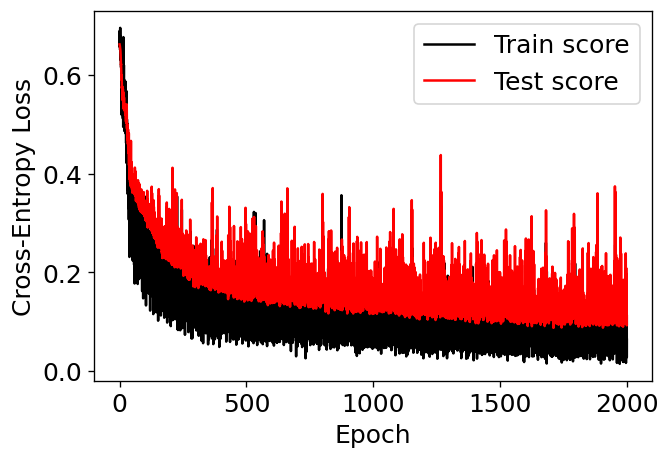

Optimal epoch count for the current training: 1710
RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:57<00:00, 17.00it/s]


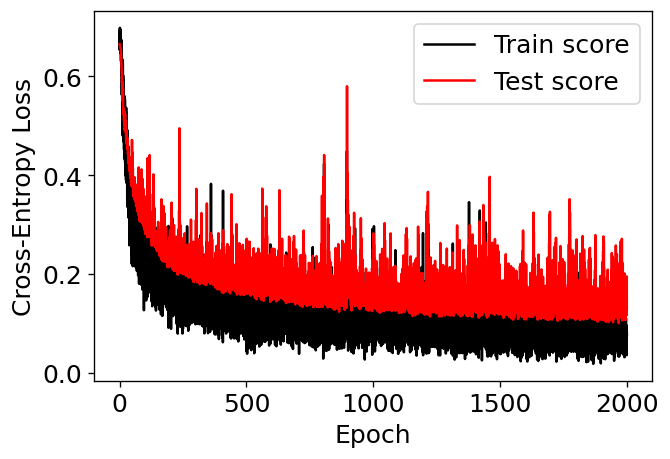

Optimal epoch count for the current training: 1967
RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:56<00:00, 17.13it/s]


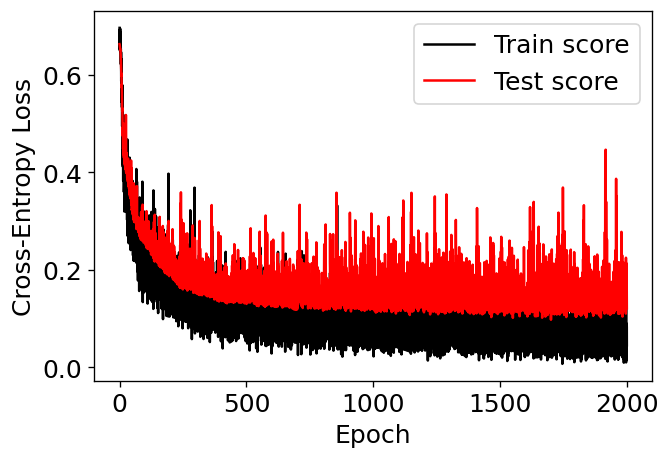

Optimal epoch count for the current training: 1700
RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:55<00:00, 17.26it/s]


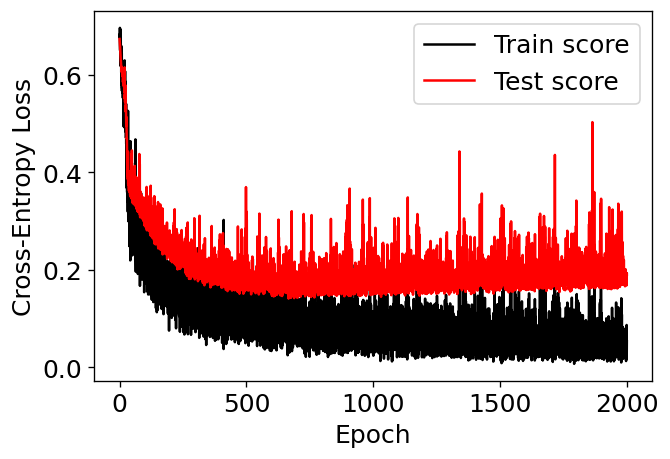

Optimal epoch count for the current training: 666
0.9484848484848485 0.8833333333333333
---------------------------------------------


100%|██████████| 2000/2000 [01:56<00:00, 17.20it/s]


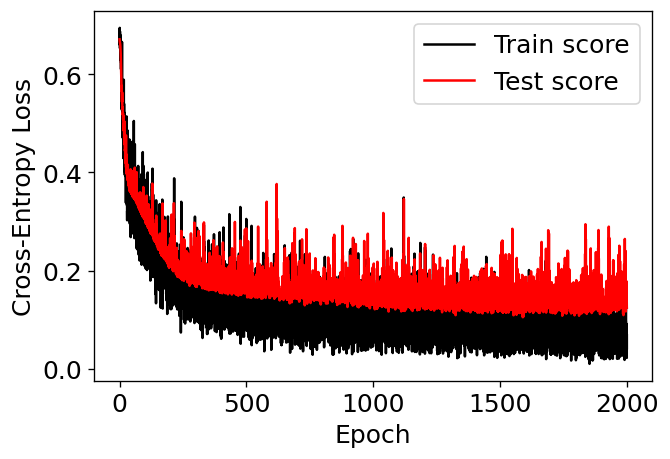

Optimal epoch count for the current training: 1589
0.9666666666666667 0.9218020541549954
---------------------------------------------


100%|██████████| 2000/2000 [01:56<00:00, 17.19it/s]


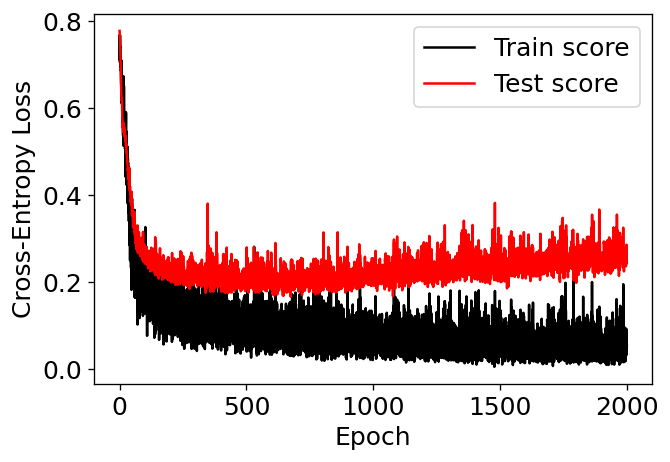

Optimal epoch count for the current training: 674
0.9515151515151515 0.8831913499344692
---------------------------------------------
TP = 117.6+/-8.06473806146238
TN = 195.1+/-8.7
FP = 5.8+/-2.1354156504062622
FN = 11.5+/-3.6674241641784495
Acc = 0.9475757575757575+/-0.014216611037260492
TSS = 0.8818830565396267+/-0.03175791970104165


In [ ]:
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e in range (0, 10, 1):

  # formation of the data set
  X_train, X_test, f_train, f_test = train_test_split(featurevector_allvdfs_all, labels_allvdfs_all, \
                                                      test_size=0.33, random_state=n_e)

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 6 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    if ((_acc < 0.92) or (optim_index > 10000)):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Experiment 4. Siamese Networks.

In [ ]:
class VDFCNN_siamese(nn.Module):
  def __init__(self):
    super(VDFCNN_siamese, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.ReLU(True)
    )
    self.mergecell = nn.Sequential(
        nn.Linear(4,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x1 = x[:,0,:,:,:]
    x2 = x[:,1,:,:,:]
    x1 = self.cnncell(x1)
    x2 = self.cnncell(x2)
    x1 = x1.view(-1, 8 * 5 * 5)
    x2 = x2.view(-1, 8 * 5 * 5)
    x1 = self.linearcell(x1)
    x2 = self.linearcell(x2)
    x = torch.cat((x1, x2), axis=1)
    x = self.mergecell(x)
    return x

In [ ]:
featurevector_allvdfs_all = np.load('allsimulations.mldata_vdfs_4040.npy')
labels_allvdfs_all = np.load('allsimulations.mldata_labels_4040.npy')
timep_array_all = np.load('allsimulations.mldata_timep_4040.npy')

featurevector_allvdfs_all = np.log10(featurevector_allvdfs_all + 1)
for t in range (0, featurevector_allvdfs_all.shape[0], 1):
  featurevector_allvdfs_all[t,0,:,:] /= np.amax(featurevector_allvdfs_all[t,0,:,:])
  featurevector_allvdfs_all[t,1,:,:] /= np.amax(featurevector_allvdfs_all[t,1,:,:])

In [ ]:
X_train_siamese = []
y_train_siamese = []

dataset_size = 20000
dataset_size_current = 0
while (dataset_size_current < dataset_size):
  i1 = random.randint(0, len(featurevector_allvdfs_all)-1)
  i2 = random.randint(0, len(featurevector_allvdfs_all)-1)
  label_1 = labels_allvdfs_all[i1]
  label_2 = labels_allvdfs_all[i2]
  if ( ((dataset_size_current % 2 == 1) and (label_1 == label_2)) or ((dataset_size_current % 2 == 0) and (label_1 != label_2)) ):
    X_train_siamese.append([featurevector_allvdfs_all[i1,:,:,:],featurevector_allvdfs_all[i2,:,:,:]])
    y_train_siamese.append(dataset_size_current % 2)
    dataset_size_current += 1

X_train_siamese = np.array(X_train_siamese)
y_train_siamese = np.array(y_train_siamese)

print(X_train_siamese.shape)
print(y_train_siamese.shape)

(20000, 2, 2, 40, 40)
(20000,)


In [ ]:
X_train, X_test, f_train, f_test = train_test_split(X_train_siamese, y_train_siamese, test_size=0.33)

In [ ]:
device = torch.device("cuda:0")
net = VDFCNN_siamese().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

loss_history_train = []
loss_history_test = []

outputs_history_train = []
outputs_labels_train = []
outputs_history_test = []
outputs_labels_test = []

n_epochs = 100
n_iterations = dataset_size//256 # based on the total size / batch size, approximately

# test data tensors
testdata_tensor = torch.tensor(X_test).float().to(device=device)
testlabels_tensor = torch.tensor(f_test).long().to(device=device)

for ep in tqdm(range(n_epochs)):
  for n_iter in range (n_iterations):
    train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
    traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
    trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
    outputs = net(traindata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, trainlabels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history_train.append(loss.item())
    outputs_history_train.append(outputs.detach())
    outputs_labels_train.append(f_train[train_indexes])
    outputs = net(testdata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, testlabels_tensor)
    loss_history_test.append(loss.item())
    outputs_history_test.append(outputs.detach())
    outputs_labels_test.append(f_test)

100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


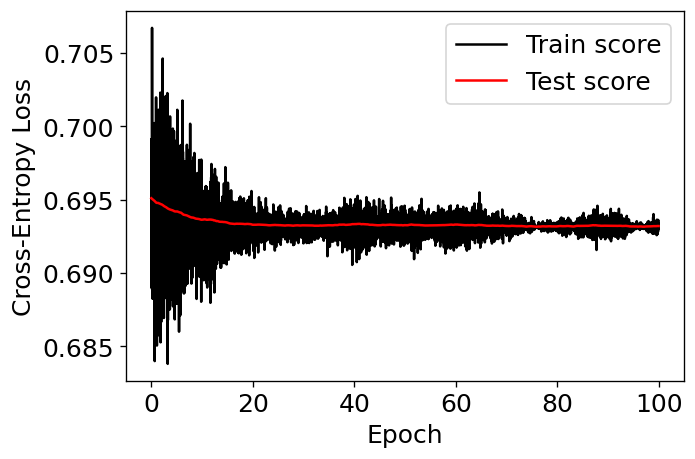

In [ ]:
matplotlib.rcParams.update({'font.size': 15})
im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
ax.legend()
plt.show()